In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import os 
from src.config import DATA_PATH, SPLITS
import pathlib

/home/javiermunoz/anaconda3/envs/tf/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"

In [5]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

## 2. Loading Video Dataset

https://www.tensorflow.org/tutorials/load_data/video

In [6]:
tf.keras.backend.clear_session()  

In [7]:
from src.frame_generator import FrameGenerator
import tensorflow as tf
from src.plot_utils import plot_history

In [8]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 0


In [9]:
n_frames = 10
batch_size = 8

# We specify the shape of the output, such as, the Generator will produce a tuple of both
# videos, class, where the videos will have 3 channels, and the rest of dimensions will remain the same.
#   VideoShape -> (F, H, W, C)
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)
# Also, we batchify the data, so the training process is not as memory consuming as if the whole dataset was 
# loaded into memory.
# VideoShape -> (B, F, H, W, C)
# train_ds = train_ds.batch(batch_size)
train_ds = train_ds.batch(batch_size)

# We reproduce this process for the validation and test splits too.
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)

val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

In [10]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [12]:
(None, *train_frames.shape[2:])

(None, 224, 224, 3)

# 3. Model definition and Training

In [13]:
model = tf.keras.Sequential([
    # Construct the input layer with no definite frame size.
    tf.keras.layers.InputLayer(input_shape=(None, *train_frames.shape[2:])),
    # Reescale the values of the pixels (per frame)
    tf.keras.layers.Rescaling(scale=255),
    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    tf.keras.layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1,1),
        stateful=False,
        return_sequences=True,
        activation="tanh",
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        strides=(1,1),
        stateful=False,
        return_sequences=False,
        activation="tanh",
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3,3),                       
        strides=(1,1),
    ),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, 224, 224, 3  0         
                             )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 222, 222, 1  11008     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 222, 222, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 220, 220, 8)       6944      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 8)      32        
 hNormalization)                                        

In [14]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

bst_model_path = "src/convlstm/bestmodels/best_simple_weights.h5"

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# Define some callbacks to improve training.
early_loss_stopping = EarlyStopping(monitor="val_loss", patience=10)
early_acc_stopping = EarlyStopping(monitor="val_accuracy", patience=10)
mod_ckpoint = ModelCheckpoint(filepath = bst_model_path, save_best_only=True, save_weights_only=True, monitor="val_accuracy")

callbacks=[
    early_loss_stopping, 
    early_acc_stopping, 
    mod_ckpoint,
    MyThresholdCallback(threshold=0.94)
]

In [15]:
# Define modifiable training hyperparameters.
epochs = 80

# Fit the model to the training data using a generator.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/80
50/50 [==============================] - 143s 861ms/step - loss: 2.9673 - accuracy: 0.0888 - val_loss: 2.3478 - val_accuracy: 0.0833
Epoch 2/80
50/50 [==============================] - 26s 524ms/step - loss: 2.2104 - accuracy: 0.2081 - val_loss: 2.2756 - val_accuracy: 0.1833
Epoch 3/80
50/50 [==============================] - 26s 523ms/step - loss: 2.0689 - accuracy: 0.2614 - val_loss: 2.1789 - val_accuracy: 0.2000
Epoch 4/80
50/50 [==============================] - 26s 526ms/step - loss: 1.9636 - accuracy: 0.3274 - val_loss: 2.1498 - val_accuracy: 0.1167
Epoch 5/80
50/50 [==============================] - 26s 525ms/step - loss: 1.8335 - accuracy: 0.3376 - val_loss: 1.9701 - val_accuracy: 0.2333
Epoch 6/80
50/50 [==============================] - 26s 527ms/step - loss: 1.6977 - accuracy: 0.4086 - val_loss: 1.9187 - val_accuracy: 0.3000
Epoch 7/80
50/50 [==============================] - 26s 530ms/step - loss: 1.5372 - accuracy: 0.4975 - val_loss: 1.7537 - val_accuracy: 0.400

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
6/6 [==============================] - 12s 2s/step - loss: 0.4484 - accuracy: 0.8261
test loss, test acc: [0.4484325051307678, 0.8260869383811951]


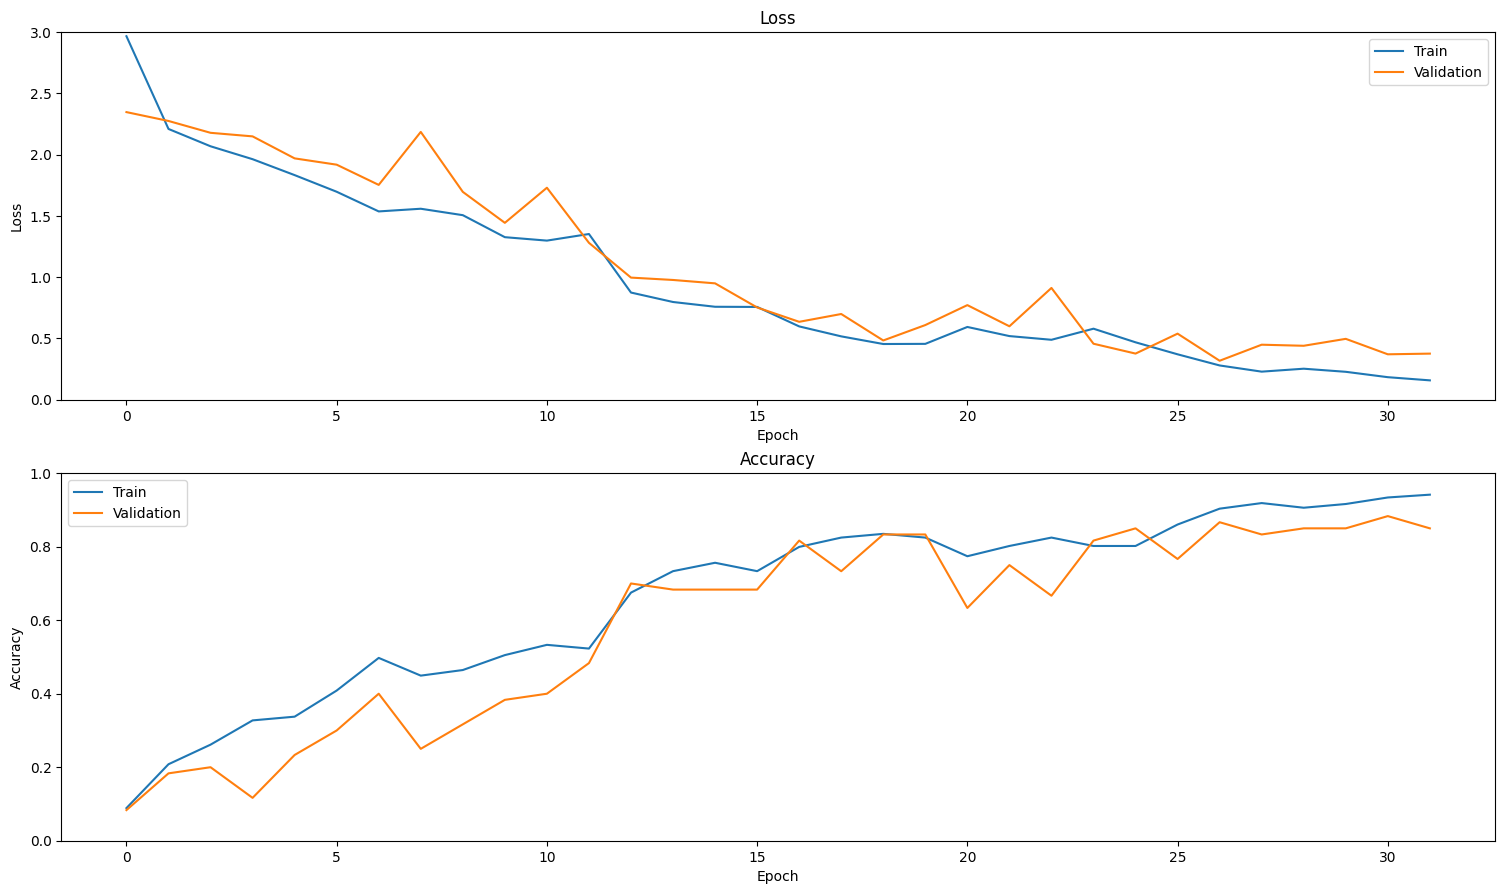

In [17]:
plot_history(history)